# Figure 1

In [1]:
## Basics
import pandas as pd
import numpy as np
import math
import string
from scipy.stats import entropy, mannwhitneyu, wilcoxon

## Bio functions
from Bio import SeqIO
from Bio.Seq import Seq

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499'}

## Functions

In [2]:
def get_aa_freqs(seq, counts = False, sort_output = True, gaps = False):
    """
    Arguments:
    seq: a sequences (string representing a protein, drawn from the 20 naturally-occuring amino acids)
    counts: bool, whether to return the counts in each category or the frequencies. False (returns freqs) by default.
    sort_output: bool, whether to return the frequencies or counts in alphabetically sorted order. True by default.
    If false, the categories will also be returned.
    Returns:
    aas: if unsorted, an iterable of the categories (amino acids) represented for each sequence
    freqs: an interable of the frequency of each category in the sequence.
        The indices match the categories in the same index in 'aas'.
        If counts is True, this will be raw counts rather than frequency.
        If sort_output is True only the frequencies will be returned, the assumed order is the
        amino acids in alphabetical order.
    """
    # Amino acids
    forbidden = ['B', 'J', 'O', 'U', 'X', 'Z']
    aas = []
    for a in string.ascii_uppercase:
        if a not in forbidden:
            aas.append(a)
    if gaps:
        aas.append('-')
    
    all_seq_aas = []
    all_seq_freqs = []
    
    # Parse sequence
    seq = seq.upper().strip("*")
    seq = list(seq)
    seq_aas, seq_counts = np.unique(seq, return_counts=True)
    zero_freq_aas = np.setxor1d(aas, seq_aas)

    seq_aas = np.append(seq_aas, zero_freq_aas)
    seq_freqs = np.append(seq_counts, np.zeros(zero_freq_aas.size))
    if not counts:
        seq_freqs = seq_freqs / len(seq)

    if sort_output:
        seq_freqs_sorted = seq_freqs[seq_aas.argsort()]
        all_seq_freqs.append(seq_freqs_sorted)

    else:
        all_seq_aas.append(seq_aas)
        all_seq_freqs.append(seq_freqs)
    
    if sort_output:
        return(all_seq_freqs)
    else:
        return(all_seq_aas, all_seq_freqs)

In [3]:
def calculate_seq_complexity(seq, typ='k1', norm=False, test=False):
    """
    Given a sequence (seq; str), return the sequence complexity in terms of 'Complexity' (type='k1', default)
    or entropy (type='k2')
    Entropy normalization (only valid for type='k2') can be to the yeast proteome frequencies (norm='yeast')
        or equiprobable amino acids (norm='uniform') 
    Assumes natural log base (could switch to base 20 later)
    """
    L = len(seq)
    yeast_H_lang = 2.8947654337060476
    uniform_H_lang = 2.3261019050474445
    charged_H_lang = entropy([0.125]*4 + [0.03125]*16)
    #charged_H_lang = 2.8910826448010822
    
    
    # Calculate complexity vector
    sj = get_aa_freqs(seq, counts=True)[0]
    sj[::-1].sort()
    
    if typ == "k1":
        num = math.factorial(L)
        denom = 1
        for n in sj:
            denom *= math.factorial(n)
        omega = num / denom
        complexity = (1 / L) * np.log(omega)
        
    if typ == "k2":
        complexity = 0
        for n in sj:
            if n != 0:
                complexity += (n / L) * (np.log(n / L))
        complexity = -1*complexity
        
        if norm == 'yeast':
            complexity = complexity / yeast_H_lang
        elif norm == 'uniform':
            complexity = complexity / uniform_H_lang
        elif norm == 'charged':
            complexity = complexity / charged_H_lang
        else:
            raise ValueError("Normalization ('norm') can be 'yeast', 'charged', or 'uniform'")
        
        if test:
            print(sj)
            print(complexity)
            
            cj = get_aa_freqs(seq)[0]
            cj[::-1].sort()
            print(cj)
            print(entropy(cj))

    
    return(complexity)

## Data

In [4]:
charged_hits = pd.read_table("../../data/charged_regions/cr_trimmed_raw.csv",
                           sep = ',', skiprows = 0, comment='#')
charged_hits = charged_hits[charged_hits['orf_label']!='dubious'] # Filter out dubious orfs

In [5]:
print("{0} regions in {1} proteins".format(len(charged_hits), len(charged_hits['gene'].unique())))

1047 regions in 800 proteins


## 1C: Data Summary

In [6]:
charged_hits.head()

,Unnamed: 0,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,uni_id,orf_label,kappa
0,0,YAL011W,SWC3,626,5,53,RTRSKESSIEQKPASRTRTRSRRGKRGRDDDDDDDDEESDDAYDEVGND,49,0.017593,0.591837,P31376,verified,0.539053
1,1,YAL011W,SWC3,626,169,261,RLFILKNDKIEQKWQDEQELKKKEKELKRKNDAEAKRLRMEERKRQ...,93,0.052936,0.559140,P31376,verified,0.098538
2,2,YAL011W,SWC3,626,361,424,KTAATEPEPKKADDENAEKQQSKEAKTTAESTQVDVKKEEEDVKEK...,64,0.007812,0.500000,P31376,verified,0.089231
3,3,YAL011W,SWC3,626,470,525,KSVVEFLEDTDEIIISWIVIHNSKEIEKFKTKKIKAKLKADQKLNK...,56,0.000714,0.428571,P31376,verified,0.265395
4,4,YAL013W,DEP1,406,84,159,ESLKRPHEDEKEAIDEAKKMKVPGENEDESKEEEKSQELEEAIDSK...,76,0.138444,0.592105,P31385,verified,0.219047


In [7]:
charged_hits['n_K'] = charged_hits.apply(lambda row: row['region.seq'].count('K'), axis=1)
charged_hits['n_R'] = charged_hits.apply(lambda row: row['region.seq'].count('R'), axis=1)
charged_hits['n_E'] = charged_hits.apply(lambda row: row['region.seq'].count('E'), axis=1)
charged_hits['n_D'] = charged_hits.apply(lambda row: row['region.seq'].count('D'), axis=1)

charged_hits['net_charge'] = charged_hits.apply(lambda row: (row['n_K'] + row['n_R']) - (row['n_D'] + row['n_E']), axis=1)
charged_hits['net_charge_per_len'] = charged_hits.apply(lambda row: row['net_charge'] / row['region.len'], axis=1)
charged_hits.head()

,Unnamed: 0,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,uni_id,orf_label,kappa,n_K,n_R,n_E,n_D,net_charge,net_charge_per_len
0,0,YAL011W,SWC3,626,5,53,RTRSKESSIEQKPASRTRTRSRRGKRGRDDDDDDDDEESDDAYDEVGND,49,0.017593,0.591837,P31376,verified,0.539053,3,9,5,12,-5,-0.102041
1,1,YAL011W,SWC3,626,169,261,RLFILKNDKIEQKWQDEQELKKKEKELKRKNDAEAKRLRMEERKRQ...,93,0.052936,0.559140,P31376,verified,0.098538,27,7,15,3,16,0.172043
2,2,YAL011W,SWC3,626,361,424,KTAATEPEPKKADDENAEKQQSKEAKTTAESTQVDVKKEEEDVKEK...,64,0.007812,0.500000,P31376,verified,0.089231,14,0,12,6,-4,-0.062500
3,3,YAL011W,SWC3,626,470,525,KSVVEFLEDTDEIIISWIVIHNSKEIEKFKTKKIKAKLKADQKLNK...,56,0.000714,0.428571,P31376,verified,0.265395,12,0,7,5,0,0.000000
4,4,YAL013W,DEP1,406,84,159,ESLKRPHEDEKEAIDEAKKMKVPGENEDESKEEEKSQELEEAIDSK...,76,0.138444,0.592105,P31385,verified,0.219047,9,2,25,9,-23,-0.302632


In [8]:
np.min(charged_hits['frac.charge'])

0.4285714285714285

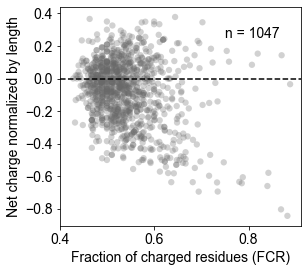

In [9]:
plt.figure(figsize=(4.5,4))
sns.scatterplot(x = charged_hits['frac.charge'], y = charged_hits['net_charge_per_len'],\
                s=40, color="dimgrey", edgecolor='none', alpha=0.3)
plt.axhline(0, linestyle='--', color='black')
plt.annotate("n = {}".format(len(charged_hits)), xy=(0.75,0.25), xycoords='data')
plt.xlabel('Fraction of charged residues (FCR)')
plt.ylabel('Net charge normalized by length')
plt.yticks(np.arange(-0.8, 0.4, 0.2))
plt.xticks(np.arange(0.4, 0.81, 0.2))
plt.tight_layout()
plt.savefig('./plots/Figure1C.png', dpi=500)
plt.show()

## 1D: Sequence complexity

In [10]:
fullseqs = {}
for seq_record in SeqIO.parse("../../data/ref_proteomes/Saccharomyces_cerevisiae.fasta", "fasta"):
    fullseqs[seq_record.id] = str(seq_record.seq)

In [11]:
# Calculate complexity of charged regions and compare to randomly drawn:

cr_seqs = list(charged_hits["region.seq"])
cr_complexities = []
rd_complexities = []
for seq in cr_seqs:
    cr_complexities.append(calculate_seq_complexity(seq, typ='k2', norm='yeast'))
    seq_L = len(seq)
    
    random_orf = np.random.choice(list(fullseqs.keys()))
    random_seq = fullseqs[random_orf]
    while len(random_seq) <= seq_L+1:
        random_orf = np.random.choice(list(fullseqs.keys()))
        random_seq = fullseqs[random_orf]
    try:
        start = np.random.randint(0, high=(len(random_seq) - (seq_L + 1)))
    except ValueError:
        print(len(random_seq) - (seq_L + 1))
    end = start+seq_L
    random_region = random_seq[start:end]
    rd_complexities.append(calculate_seq_complexity(random_region, typ='k2', norm='yeast'))

In [12]:
# Calculate complexity of charged regions and compare to randomly drawn:

cr_seqs = list(charged_hits["region.seq"])
cr_complexities = []
cr_charge_norm = []
rd_complexities = []
for seq in cr_seqs:
    cr_complexities.append(calculate_seq_complexity(seq, typ='k2', norm='yeast'))
    cr_charge_norm.append(calculate_seq_complexity(seq, typ='k2', norm='charged'))
    seq_L = len(seq)
    
    random_orf = np.random.choice(list(fullseqs.keys()))
    random_seq = fullseqs[random_orf]
    while len(random_seq) <= seq_L+1:
        random_orf = np.random.choice(list(fullseqs.keys()))
        random_seq = fullseqs[random_orf]
    try:
        start = np.random.randint(0, high=(len(random_seq) - (seq_L + 1)))
    except ValueError:
        print(len(random_seq) - (seq_L + 1))
    end = start+seq_L
    random_region = random_seq[start:end]
    rd_complexities.append(calculate_seq_complexity(random_region, typ='k2', norm='yeast'))

In [13]:
wilcoxon(cr_charge_norm, rd_complexities)

WilcoxonResult(statistic=69454.0, pvalue=2.7209115000321306e-97)

In [14]:
mannwhitneyu(cr_charge_norm, rd_complexities, alternative="less")

MannwhitneyuResult(statistic=213465.0, pvalue=1.4316283608713918e-129)

In [15]:
#Adding LCR references

# Riback and Katanski 2017 
Pab1_lcr = "YQQATAAAAAAAAGMPGQFMPPMFYGVMPPRGVPFNGPNPQQMNPMGGMPKNGMPPQFRNGPVYGVPPQGGFPRNANDNNQFYQQ"
Pab1_complexity = calculate_seq_complexity(Pab1_lcr, typ='k2', norm='yeast')
print(Pab1_complexity)

# https://www.uniprot.org/uniprot/P05453
Sup35_prd = "NQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYYQNYQGYSGYQQGGYQQYNPDAGYQQQYNPQGGYQQYNPQGGYQQQFNPQGGRGNYKNFNYNNNLQGYQAGFQPQSQGMSLNDFQKQQKQ"
Sup35_prd_complexity = calculate_seq_complexity(Sup35_prd, typ='k2', norm='yeast')
print(Sup35_prd_complexity)
Sup35_charged = "KPKKTLKLVSSSGIKLANATKKVGTKPAESDKKEEEKSAETKEPTKEPTKVEEPVKKEEKPVQTEEKTEEKSELPKVEDLKISESTHNTNNANVTSADALIKEQEEEVDDE"
Sup35_charged_complexity = calculate_seq_complexity(Sup35_charged, typ='k2', norm="yeast")
print(Sup35_charged_complexity)

# https://www.uniprot.org/uniprot/P60010
actin = "MDSEVAALVIDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGIMVGMGQKDSYVGDEAQSKRGILTLRYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPMNPKSNREKMTQIMFETFNVPAFYVSIQAVLSLYSSGRTTGIVLDSGDGVTHVVPIYAGFSLPHAILRIDLAGRDLTDYLMKILSERGYSFSTTAEREIVRDIKEKLCYVALDFEQEMQTAAQSSSIEKSYELPDGQVITIGNERFRAPEALFHPSVLGLESAGIDQTTYNSIMKCDVDVRKELYGNIVMSGGTTMFPGIAERMQKEITALAPSSMKVKIIAPPERKYSVWIGGSILASLTTFQQMWISKQEYDESGPSIVHHKCF"
start = np.random.choice(np.arange(len(actin)-len(Sup35_prd)-1))
actin_sub = actin[start:start+len(Sup35_prd)]
actin_complexity = calculate_seq_complexity(actin_sub, typ='k2', norm='yeast')
print(actin_complexity)

0.7959440135238849
0.7065693164263049
0.8082157483689584
0.9728622669859509


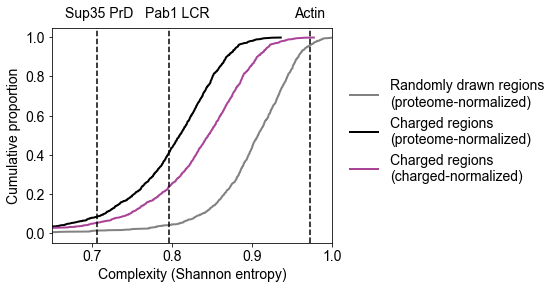

In [17]:
fig, ax = plt.subplots(figsize=(8,4.25))

ax.plot(np.sort(rd_complexities), np.linspace(0, 1, len(rd_complexities), endpoint=False),
        label='Randomly drawn regions\n(proteome-normalized)', linewidth=2, color = cscheme['dis'])
ax.plot(np.sort(cr_complexities), np.linspace(0, 1, len(cr_complexities), endpoint=False),
        label="Charged regions\n(proteome-normalized)", linewidth=2, color = 'black')
ax.plot(np.sort(cr_charge_norm), np.linspace(0, 1, len(cr_charge_norm), endpoint=False),
        label="Charged regions\n(charged-normalized)", linewidth=2, color = cscheme['cr'])
ax.annotate('Pab1 LCR',
            xy=(Pab1_complexity-0.03, 1.1), annotation_clip=False)
ax.axvline(Pab1_complexity, linestyle='--', color='black')

ax.annotate('Sup35 PrD',
            xy=(Sup35_prd_complexity-0.04, 1.1), annotation_clip=False)
ax.axvline(Sup35_prd_complexity, linestyle='--', color='black')

ax.annotate('Actin',
            xy=(actin_complexity-0.02, 1.1), annotation_clip=False)
ax.axvline(actin_complexity, linestyle='--', color='black')

plt.legend(bbox_to_anchor=(1.02, 0.82), loc='upper left', fontsize=14, frameon=False)
plt.xlabel("Complexity (Shannon entropy)")
plt.ylabel("Cumulative proportion")
plt.xlim((0.65, 1))
plt.tight_layout()
plt.savefig('./plots/Figure1D.png', dpi=500)
plt.show()